In [31]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_working_channel_impedance_by_days_with_sem(data_by_category, output_path):
    """
    Plot mean ± SEM impedance over time using days since first recording as x-axis,
    and save the plot to a PDF file.

    Args:
        data_by_category (dict): Dictionary with impedance time series data per category.
        output_path (str): Full path to the output PDF file.
    """
    plt.figure(figsize=(10, 6))

    for category, data in data_by_category.items():
        dates = [entry["date"] for entry in data["time_series"]]
        first_date = dates[0]
        days_since_start = [(date - first_date).days for date in dates]

        means = []
        sems = []

        for entry in data["time_series"]:
            impedances = entry["reference_impedances"]
            working = [imp for imp in impedances if imp < 5e6]

            if working:
                mean_val = np.mean(working)
                sem_val = np.std(working, ddof=1) / np.sqrt(len(working))
                means.append(mean_val)
                sems.append(sem_val)
            else:
                means.append(None)
                sems.append(None)

        plt.errorbar(days_since_start[1:], means[1:], yerr=sems[1:], label=category, marker='o', capsize=3)

    plt.xlabel("Equivalent Days of Aging Since First Recording")
    plt.ylabel("Mean Impedance of Working Channels (ohms)")
    plt.title("Mean ± SEM Impedance of Working Channels Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plotname = "mean_impedances.pdf"
    # Save as PDF
    plt.savefig(os.path.join(output_path, plotname), format='pdf')
    plt.show()

    print(f"\n✅ Plot saved as PDF to: {output_path}")

    
def save_working_channel_counts(data_by_category, output_dir):
    """
    Saves a CSV file of number of working channels over time per category.

    Args:
        data_by_category (dict): Data structure with time_series info.
        output_dir (str): Path where CSV will be saved.
    """
    # Collect all unique dates across categories
    all_dates = set()
    for data in data_by_category.values():
        for entry in data["time_series"]:
            all_dates.add(entry["date"])
    all_dates = sorted(all_dates)

    # Create a DataFrame indexed by date
    df = pd.DataFrame(index=all_dates)

    # Fill DataFrame with counts from each category
    for category, data in data_by_category.items():
        date_to_count = {entry["date"]: entry["num_working"] for entry in data["time_series"]}
        df[category] = df.index.map(lambda d: date_to_count.get(d, None))

    # Save to CSV
    output_path = os.path.join(output_dir, "working_channels_summary.csv")
    df.index.name = "Date"
    df.to_csv(output_path)

    print(f"\n✅ CSV saved to: {output_path}")

In [46]:

# Define the root path
root_path = "/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/"

# Dictionary to hold all data
data_by_category = {}
up_thr = 5e5
low_thr = 3e4

print("\n=== Impedance Analysis ===")

# Loop through each category folder
for category in os.listdir(root_path):
    category_path = os.path.join(root_path, category)
    
    if os.path.isdir(category_path):
        entries = []

        print(f"\nProcessing Category: {category}")

        for file_name in os.listdir(category_path):
            if file_name.endswith(".csv"):
                try:
                    date_str = os.path.splitext(file_name)[0]
                    file_date = datetime.strptime(date_str, "%Y%m%d").date()
                except ValueError:
                    print(f"  Skipping file with invalid date format: {file_name}")
                    continue

                file_path = os.path.join(category_path, file_name)
                try:
                    df = pd.read_csv(file_path)
                    col_name = "Impedance Magnitude at 1000 Hz (ohms)"
                    if col_name in df.columns:
                        impedances = df[col_name].dropna().tolist()
                        entries.append({
                            "date": file_date,
                            "impedances": impedances
                        })
                    else:
                        print(f"  Column missing in {file_name}")
                except Exception as e:
                    print(f"  Error reading {file_name}: {e}")
        
        # Sort by date
        entries.sort(key=lambda x: x["date"])

        if entries:
            first_entry = entries[0]
            reference_indices = [i for i, imp in enumerate(first_entry["impedances"]) if imp < up_thr and imp > low_thr]
            print(f"  First date: {first_entry['date']}")
            print(f"  Reference working channels (imp < {up_thr} and > {low_thr}Ω): {len(reference_indices)}")
            print("Category: "+category)
            print("Initial mean impedance: ")
            print(np.mean(np.array(first_entry["impedances"])[reference_indices]))
            processed_entries = []
            for entry in entries:
                date = entry["date"]
                reference_impedances = [entry["impedances"][i] for i in reference_indices if i < len(entry["impedances"])]
                still_working = [imp for imp in reference_impedances if imp < up_thr and imp > low_thr ]

                print(f"    {date}: {len(still_working)} of {len(reference_indices)} still < {up_thr} and > {low_thr}Ω")

                processed_entries.append({
                    "date": date,
                    "reference_impedances": reference_impedances,
                    "num_working": len(still_working),
                    "total_reference": len(reference_indices)
                })

            data_by_category[category] = {
                "reference_indices": reference_indices,
                "time_series": processed_entries
            }

print("\n=== Done ===")

# Usage
main_folder = "/Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/"
save_working_channel_counts(data_by_category, output_dir=main_folder)


=== Impedance Analysis ===

Processing Category: mrid3(duo)
  First date: 2025-08-08
  Reference working channels (imp < 500000.0 and > 30000.0Ω): 52
Category: mrid3(duo)
Initial mean impedance: 
63232.692307692305
    2025-08-08: 52 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-11: 30 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-13: 28 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-15: 39 of 52 still < 500000.0 and > 30000.0Ω
    2025-08-18: 47 of 52 still < 500000.0 and > 30000.0Ω

Processing Category: control2
  Skipping file with invalid date format: 20250722_pbs.csv
  First date: 2025-07-22
  Reference working channels (imp < 500000.0 and > 30000.0Ω): 50
Category: control2
Initial mean impedance: 
57080.0
    2025-07-22: 50 of 50 still < 500000.0 and > 30000.0Ω
    2025-07-23: 47 of 50 still < 500000.0 and > 30000.0Ω
    2025-07-25: 46 of 50 still < 500000.0 and > 30000.0Ω
    2025-07-28: 43 of 50 still < 500000.0 and > 30000.0Ω
    2025-07-31: 33 of 50 still < 500000

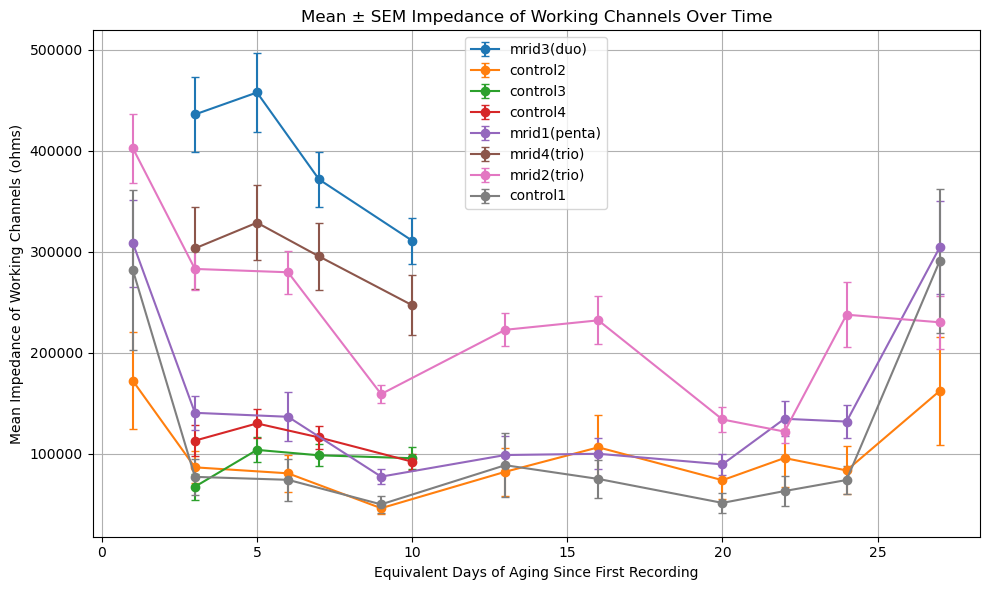


✅ Plot saved as PDF to: /Users/eminhanozil/Yanik Lab Dropbox/Eminhan Özil/Localization Manuscript 2024/in vitro/Accelerated Aging/impedances/


In [47]:
plot_working_channel_impedance_by_days_with_sem(data_by_category, main_folder)

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def compute_percentages(df_in: pd.DataFrame):
    if "Date" not in df_in.columns:
        raise ValueError('Input must contain a "Date" column.')

    df = df_in.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    if df["Date"].isna().any():
        bad = df[df["Date"].isna()].index.tolist()
        raise ValueError(f"Unparseable dates at rows: {bad}")

    df = df.sort_values("Date")

    categories = [c for c in df.columns if c != "Date"]

    # earliest non-NaN baseline per category
    baselines = {}
    for c in categories:
        s = df[c].dropna()
        baselines[c] = s.iloc[0] if not s.empty else float("nan")

    pct = df[categories].div(pd.Series(baselines), axis=1) * 100.0
    pct_df = pd.concat([df[["Date"]], pct], axis=1)
    return pct_df, baselines
    
from typing import Optional, Union

def plot_per_category(
    pct_df: pd.DataFrame,
    save_dir: Optional[Union[str, Path]] = None,
    show: bool = True
):
    date = pct_df["Date"]
    for col in [c for c in pct_df.columns if c != "Date"]:
        series = pct_df[col]
        if series.dropna().empty:
            continue

        plt.figure()
        plt.plot(date, series, marker="o")
        plt.title(f"{col} — % of baseline over time")
        plt.xlabel("Date")
        plt.ylabel("% of baseline")
        plt.grid(True, which="both", linestyle="--", alpha=0.5)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        if save_dir is not None:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            out_path = save_dir / f"{col.replace('/', '_')}_percentage.png"
            plt.savefig(out_path, dpi=150)

        if show:
            plt.show()
        else:
            plt.close()

# Example usage:
# plot_per_category(pct_df, save_dir="percent_plots", show=True)
# plot_per_category(pct_df, save_dir=None, show=True)


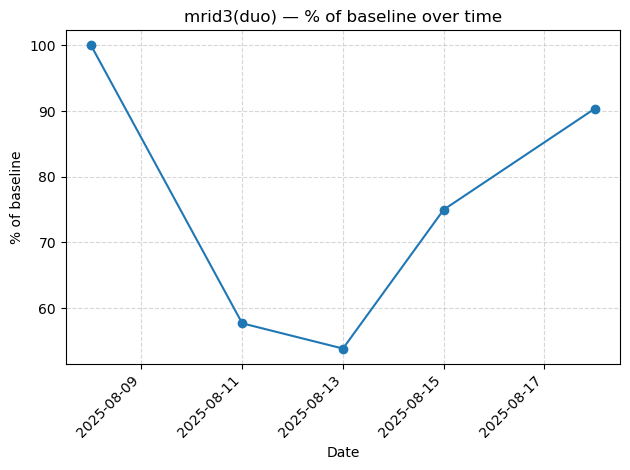

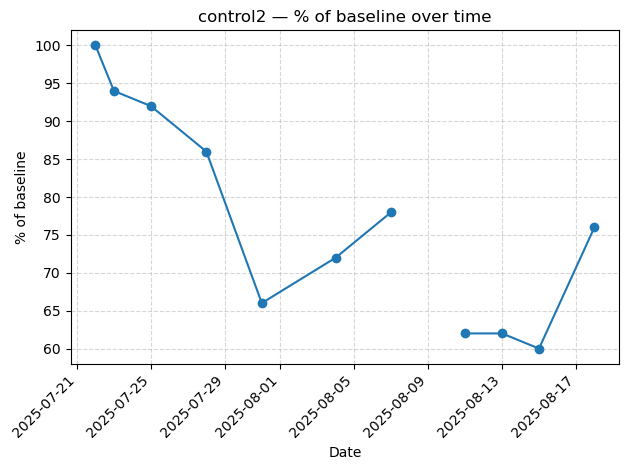

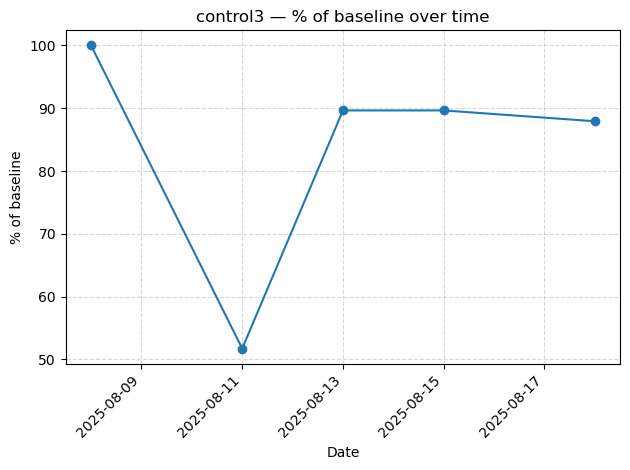

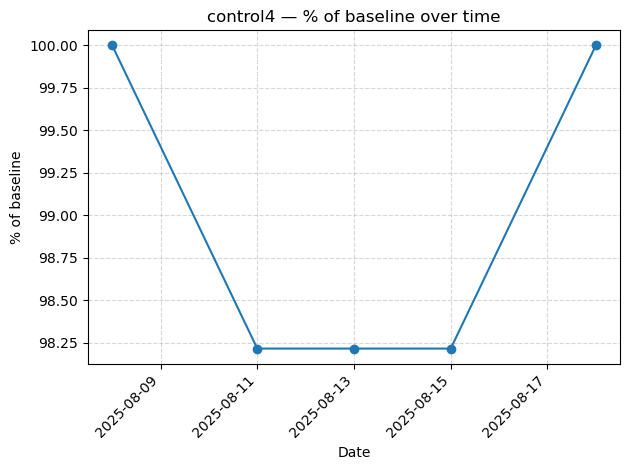

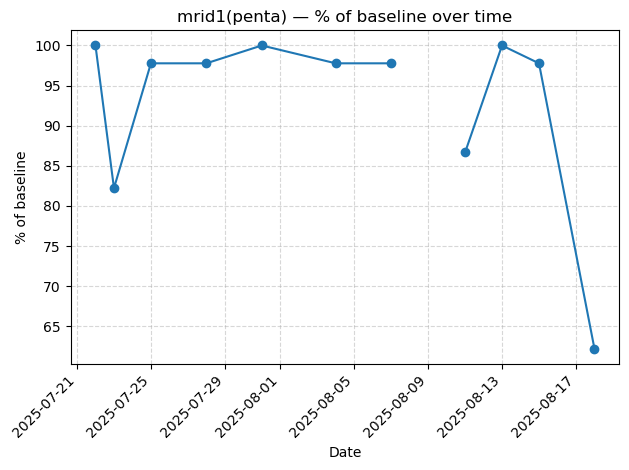

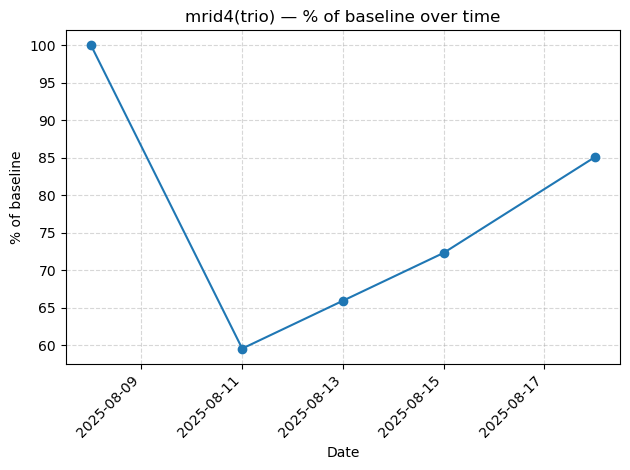

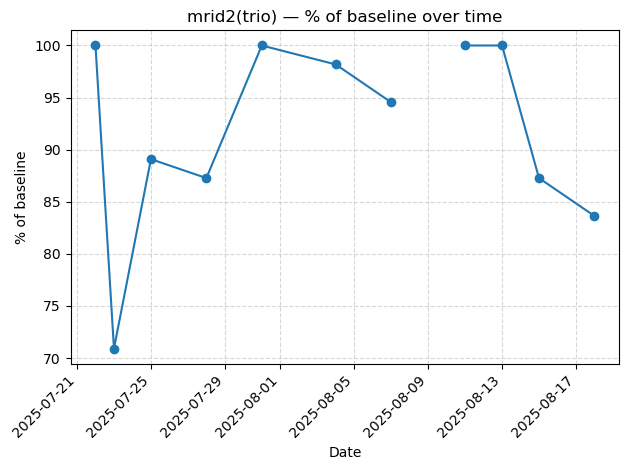

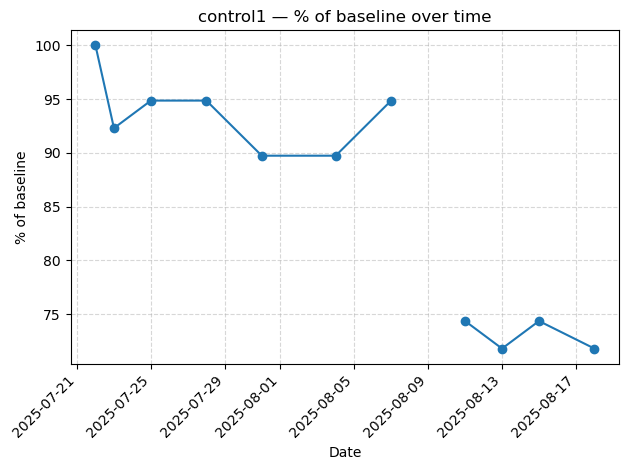

In [55]:
csv_path = os.path.join(main_folder, "working_channels_summary.csv")  # <- change if your file is elsewhere
df = pd.read_csv(csv_path)
df.head()

pct_df, baselines = compute_percentages(df)
pct_df.head()
plot_per_category(pct_df, save_dir=None, show=True)

In [56]:
pct_df

,Date,mrid3(duo),control2,control3,control4,mrid1(penta),mrid4(trio),mrid2(trio),control1
0,2025-07-22,NaN,100.0,NaN,NaN,100.000000,NaN,100.000000,100.000000
1,2025-07-23,NaN,94.0,NaN,NaN,82.222222,NaN,70.909091,92.307692
2,2025-07-25,NaN,92.0,NaN,NaN,97.777778,NaN,89.090909,94.871795
3,2025-07-28,NaN,86.0,NaN,NaN,97.777778,NaN,87.272727,94.871795
4,2025-07-31,NaN,66.0,NaN,NaN,100.000000,NaN,100.000000,89.743590
5,2025-08-04,NaN,72.0,NaN,NaN,97.777778,NaN,98.181818,89.743590
6,2025-08-07,NaN,78.0,NaN,NaN,97.777778,NaN,94.545455,94.871795
7,2025-08-08,100.000000,NaN,100.000000,100.000000,NaN,100.000000,NaN,NaN
8,2025-08-11,57.692308,62.0,51.724138,98.214286,86.666667,59.574468,100.000000,74.358974
9,2025-08-13,53.846154,62.0,89.655172,98.214286,100.000000,65.957447,100.000000,71.794872
